In [1]:
import pandas as pd
import os
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
def stock_selector(ticker):
    data = yf.Ticker(ticker)
    data = data.history(period="max")
    
    del data["Dividends"]
    del data["Stock Splits"]

    data.plot.line(y="Close", use_index=True, title=f"{ticker} Close Price Over Time")

    data["Tomorrow"] = data["Close"].shift(-1)
    data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

    data = data.loc["1990-01-01":].copy()
    return data

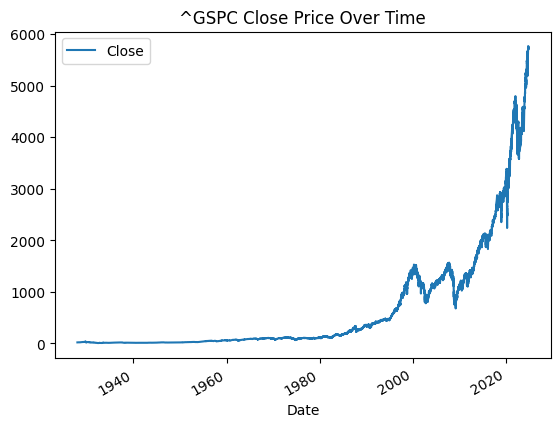

In [3]:
sp_500 = stock_selector("^GSPC")

In [4]:
#BTC = stock_selector("BTC-USD")

In [5]:
def model_init(estimators, min_sample):
    model = RandomForestClassifier(n_estimators=estimators, min_samples_split=min_sample, random_state=1)
    return model

In [6]:
model = model_init(100,100)

In [7]:
#train = sp_500.iloc[:-300]
#test = sp_500.iloc[-300:]
#predictors = ["Close", "Volume", "Open", "High", "Low"]
#model.fit(train[predictors], train["Target"])

#preds = model.predict(test[predictors])
#preds = pd.Series(preds, index=test.index)
#p_score = precision_score(test["Target"], preds)
#print(f"Precision Score: {p_score}")
#combined = pd.concat([test["Target"], preds], axis=1)
#print(combined)
#combined.plot()

In [8]:
# Training set target distribution
#print("Training target distribution:")
#print(train["Target"].value_counts())

# Test set target distribution
#print("\nTest target distribution:")
#print(test["Target"].value_counts())

#feature_importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
#print("Feature importances:\n", feature_importances)


In [9]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [14]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    solution = pd.concat(all_predictions)
    value_counts = solution["Predictions"].value_counts()
    print(f"Value Counts: {value_counts}")

    p_score = precision_score(solution["Target"], solution["Predictions"])
    print(f"Precision Score: {p_score}")

    target_percentage = solution["Target"].value_counts() / solution.shape[0]
    print(f"Target Percentage: {target_percentage}")

In [16]:
backtest(sp_500, model, predictors=["Close", "Volume", "Open", "High", "Low"])

Value Counts: Predictions
0    3658
1    2602
Name: count, dtype: int64
Precision Score: 0.5292083013066872
Target Percentage: Target
1    0.535783
0    0.464217
Name: count, dtype: float64


In [12]:
# Time horizons for the last; 2-days, 1-week, 3-months, 1-year & 4-years
horizons = [2,4,60,250,1000]
new_predictors = []

# Loop through horizons and creating rolling average
for horizon in horizons:
    rolling_averages = sp_500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp_500[ratio_column] = sp_500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp_500[trend_column] = sp_500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [13]:
sp_500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_4,Trend_4,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,0.987717,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.996297,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-02 00:00:00-04:00,5698.140137,5719.629883,5674.000000,5709.540039,3829050000,5699.939941,0,1.000069,1.0,0.996475,2.0,1.028863,34.0,1.124111,147.0,1.303107,527.0
2024-10-03 00:00:00-04:00,5698.189941,5718.779785,5677.370117,5699.939941,3597450000,5751.069824,1,0.999159,1.0,0.996462,2.0,1.026929,33.0,1.120948,147.0,1.300273,526.0
2024-10-04 00:00:00-04:00,5737.479980,5753.209961,5702.830078,5751.069824,3479400000,5695.939941,0,1.004465,1.0,1.005902,2.0,1.035623,34.0,1.129721,147.0,1.311267,527.0


In [14]:
sp_500 = sp_500.dropna()

In [15]:
model = model_init(200,50)

In [16]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [19]:
backtest(sp_500, model, new_predictors)

Value Counts: Predictions
0.0    4351
1.0     907
Name: count, dtype: int64
Precision Score: 0.5600882028665931
Target Percentage: Target
1    0.545455
0    0.454545
Name: count, dtype: float64
